In [1]:
import time
import numpy as np

import mss
import cv2
from PIL import Image

import matplotlib.pyplot as plt

from xpc3 import *
from xpc3_helper import *

In [2]:
client = XPlaneConnect()
reset(client, dtpInit=322.0)

In [5]:
### IMPORTANT PARAMETERS FOR IMAGE PROCESSING ###
stride = 16             # Size of square of pixels downsampled to one grayscale value
numPix = 16  # During downsampling, average the numPix brightest pixels in each square
width = 256//stride    # Width of downsampled grayscale image
height = 128//stride    # Height of downsampled grayscale image
WIDTH = 360
HEIGHT = 200

In [16]:
screen_shot = mss.mss()

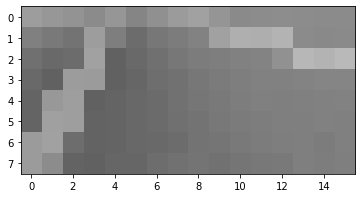

In [36]:
def computeTrainingImage():

    img = cv2.cvtColor(np.array(screen_shot.grab(screen_shot.monitors[2])),
                       cv2.COLOR_BGRA2BGR)[230:, :, :]
    img = cv2.resize(img, (WIDTH, HEIGHT))

    # img = img[230:, :, :]
    # img = cv2.resize(img, (WIDTH, HEIGHT))

    img = np.array(img)

    # Remove yellow/orange lines
    mask = ((img[:, :, 0].astype('float')-img[:, :, 2].astype('float')) >
            60) & ((img[:, :, 1].astype('float')-img[:, :, 2].astype('float')) > 30)
    img[mask] = 0

    # Convert to grayscale, crop out nose, sky, bottom of image, resize to 256x128, scale so
    # values range between 0 and 1
    img = np.array(Image.fromarray(img).convert('L').crop(
        (75, 25, 360, 135)).resize((256, 128)))/255.0

    # Downsample image
    # Split image into stride x stride boxes, average numPix brightest pixels in that box
    # As a result, img2 has one value for every box
    img2 = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            img2[i, j] = np.mean(np.sort(
                img[stride*i:stride*(i+1), stride*j:stride*(j+1)].reshape(-1))[-numPix:])

    # Ensure that the mean of the image is 0.5 and that values range between 0 and 1
    # The training data only contains images from sunny, 9am conditions.
    # Biasing the image helps the network generalize to different lighting conditions (cloudy, noon, etc)
    img2 -= img2.mean()
    img2 += 0.5
    img2[img2 > 1] = 1
    img2[img2 < 0] = 0
    return img2


img2 = computeTrainingImage()
plt.imshow(img2, clim=(0, 1), cmap='gray')

In [19]:
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]

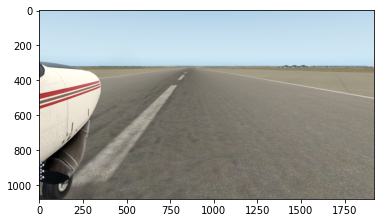

In [20]:
plt.imshow(ss)

In [39]:
setHomeState(client, 5.0, 322.0, 15.0)

In [50]:
def save_image_gray(data, fn):

    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])

    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    ax.imshow(data, cmap='gray', clim=(0,1))
    plt.savefig(fn, dpi=height)
    plt.close()


def save_image(data, fn):

    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])

    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    ax.imshow(data)
    plt.savefig(fn, dpi=height)
    plt.close()

In [40]:
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]

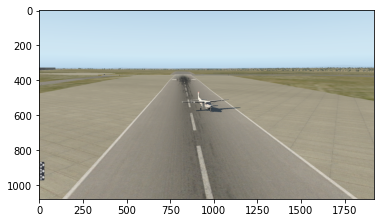

In [44]:
plt.imshow(ss)

In [47]:
save_image(ss, "taxi_environment.png")

In [42]:
ss_camera = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]

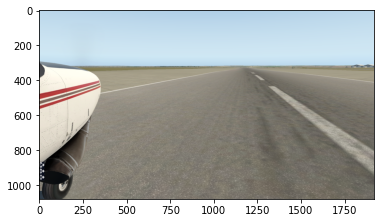

In [45]:
plt.imshow(ss_camera)

In [48]:
save_image(ss_camera, "taxi_image.png")

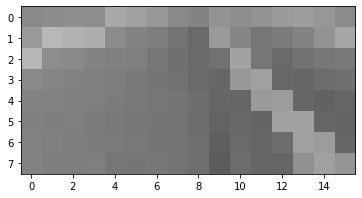

In [43]:
img2 = computeTrainingImage()
plt.imshow(img2, clim=(0, 1), cmap='gray')

In [51]:
save_image_gray(img2, "downsampled_image.png")